In [1]:
import awkward as ak
import numpy as np
import pickle
import hist
import coffea
from python.plugins import checkdir
%matplotlib inline

import matplotlib.pyplot as plt
import mplhep as hep
from mplhep.plot import soft_update_kwargs
plt.style.use([hep.style.CMS, hep.style.firamath])

In [2]:
#### Plot dijet systematics
fname = "coffeaOutput/dijet/dijetHists_JetHT_JMRJMS_rap2.5_nominal__2018.pkl"
with open(fname, "rb") as f:
    result_data = pickle.load( f )
fname = "coffeaOutput/dijet/dijetHists_wXSscaling_QCDsim_rap2.5_JMRJMS__nominal_2018.pkl"
with open(fname, "rb") as f:
    result_mc = pickle.load( f )
# fname = "coffeaOutput/trijet/trijetHists_JetHT_pt200.0_rapidity2.5_nominal2018.pkl"
# with open(fname, "rb") as f:
#     result_data = pickle.load( f )
# fname = "coffeaOutput/trijet/trijetHists_wXSscaling_QCDsim_pt200.0rapidity2.5_allUnc2018.pkl"
# with open(fname, "rb") as f:
#     result_mc = pickle.load( f )
year = fname[-8:-4]
# fname = "coffeaOutput/trijetHists_JetHT_pt200-Copy1.0_rappidity2.5_NoneHEMveto2018.pkl"
# with open(fname, "rb") as f:
#     result_mc_older = pickle.load( f )
if "trijet" in fname:
    os_path = 'plots/syst/trijet/'
else: os_path = 'plots/syst/dijet/'
# print(result_mc['cutflow'])
os_path=os_path+"test"
checkdir(os_path)

In [3]:
#### Check available uncertainties

In [4]:
def getTotSyst(result, histname, axis='mreco'):
    hist = result[histname]
    availSysts = [ax for ax in result[histname].project("syst").axes[0]]
    syst_uncorr = [
    'jerUp','jerDown'
    'PUSFUp','PUSFDown', #PDFs WIP
    'L1prefiringDown', 'L1prefiringUp', 
    'AbsoluteStatUp','AbsoluteStatDown',
    'FlavorQCDUp','FlavorQCDDown',
    'FragmentationUp','FragmentationDown',
    'PileUpDataMCUp','PileUpDataMCDown',
    'RelativeBalUp','RelativeBalDown',
    'RelativeJEREC1Up','RelativeJEREC1Down',
    'RelativeJEREC2Up','RelativeJEREC2Down',
    'RelativePtEC1Up','RelativePtEC1Down',
    'RelativePtEC2Up','RelativePtEC2Down',
    'RelativeSampleUp','RelativeSampleDown',
    'RelativeStatECUp','RelativeStatECDown',
    'RelativeStatFSRUp','RelativeStatFSRDown',
    'RelativeStatHFUp','RelativeStatHFDown',
]

    absolute = ['AbsoluteMPFBiasUp', 'AbsoluteMPFBiasDown',
                'AbsoluteScaleUp', 'AbsoluteScaleDown']
    pileuppt = ['PileUpPtBBUp', 'PileUpPtBBDown', 
                'PileUpPtEC1Up', 'PileUpPtEC1Down',
                'PileUpPtEC2Up', 'PileUpPtEC2Down', 
                'PileUpPtHFUp', 'PileUpPtHFDown', 
                'PileUpPtRefUp', 'PileUpPtRefDown']
    relpt = ['RelativePtEC1Up', 'RelativePtEC1Down','RelativePtHFUp', 'RelativePtHFDown']
    singlepion =     ['SinglePionECALUp', 'SinglePionECALDown','SinglePionHCALUp', 'SinglePionHCALDown']
    timepteta = ['TimePtEtaUp', 'TimePtEtaDown']

    availSysts = [syst for syst in availSysts if availSysts]
    syst_list = [syst for syst in availSysts if syst!="nominal" and syst not in syst_uncorr]
    syst_uncorr = [syst for syst in syst_uncorr if syst in availSysts]
    corr_grps = [absolute, pileuppt, relpt, singlepion, timepteta]
    sysErr = {}  
    for syst in availSysts:
        sysErr.update({syst: hist[{'syst':syst}].project(axis).values()})
    nom_values = hist[{'syst':'nominal'}].project(axis).values()
    sysErrTot_up = np.zeros_like(nom_values)
    sysErrTot_dn = np.zeros_like(nom_values)
    #### Loop through uncorrelated groups and make 
    for grp in corr_grps:
        grp_unc_total_up  = np.zeros_like(nom_values)
        grp_unc_total_dn  = np.zeros_like(nom_values)
        for syst in grp:
            if syst in availSysts:
                syst_vals = sysErr[syst]
                if "Up" in syst:
                    deltasys = abs(syst_vals-nom_values)
                    grp_unc_total_up += deltasys
                if "Down" in syst:
                    deltasys = abs(nom_values-syst_vals)
                    grp_unc_total_dn += deltasys
        sysErrTot_up += grp_unc_total_up**2
        sysErrTot_dn += grp_unc_total_dn**2
    #### Loop through uncorrelated uncertainties and add together with correlated groups
    for syst, syst_vals in sysErr.items():
        if "Up" in syst and syst in syst_uncorr:
            deltasys = syst_vals-nom_values
            sysErrTot_up = sysErrTot_up + deltasys**2
        if "Down" in syst and syst in syst_uncorr:
            deltasys = nom_values-syst_vals
            sysErrTot_dn = sysErrTot_dn + deltasys**2
    sysErrTot_up = sysErrTot_up**0.5
    sysErrTot_dn = sysErrTot_dn**0.5
    return sysErrTot_up, sysErrTot_dn

In [5]:
#### Function for crosschecking adding of uncertainties in TUnfold --> Should be same
def getTotSystUnrolled(result, histname, axis='mgen'):
    hist = result[histname]
    availSysts = [ax for ax in result[histname].project("syst").axes[0]]
    pt_bins = [bin[0] for bin in result[histname].project('ptgen').axes[0]]
    syst_uncorr = [
    'jerUp','jerDown'
    'PUSFUp','PUSFDown', #PDFs WIP
    'L1prefiringDown', 'L1prefiringUp', 
    'AbsoluteStatUp','AbsoluteStatDown',
    'FlavorQCDUp','FlavorQCDDown',
    'FragmentationUp','FragmentationDown',
    'PileUpDataMCUp','PileUpDataMCDown',
    'RelativeBalUp','RelativeBalDown',
    'RelativeJEREC1Up','RelativeJEREC1Down',
    'RelativeJEREC2Up','RelativeJEREC2Down',
    'RelativePtEC1Up','RelativePtEC1Down',
    'RelativePtEC2Up','RelativePtEC2Down',
    'RelativeSampleUp','RelativeSampleDown',
    'RelativeStatECUp','RelativeStatECDown',
    'RelativeStatFSRUp','RelativeStatFSRDown',
    'RelativeStatHFUp','RelativeStatHFDown',
]

    absolute = ['AbsoluteMPFBiasUp', 'AbsoluteMPFBiasDown',
                'AbsoluteScaleUp', 'AbsoluteScaleDown']
    pileuppt = ['PileUpPtBBUp', 'PileUpPtBBDown', 
                'PileUpPtEC1Up', 'PileUpPtEC1Down',
                'PileUpPtEC2Up', 'PileUpPtEC2Down', 
                'PileUpPtHFUp', 'PileUpPtHFDown', 
                'PileUpPtRefUp', 'PileUpPtRefDown']
    relpt = ['RelativePtEC1Up', 'RelativePtEC1Down','RelativePtHFUp', 'RelativePtHFDown']
    singlepion =     ['SinglePionECALUp', 'SinglePionECALDown','SinglePionHCALUp', 'SinglePionHCALDown']
    timepteta = ['TimePtEtaUp', 'TimePtEtaDown']

    availSysts = [syst for syst in availSysts if availSysts]
    syst_list = [syst for syst in availSysts if syst!="nominal" and syst not in syst_uncorr]
    syst_uncorr = [syst for syst in syst_uncorr if syst in availSysts]
    corr_grps = [absolute, pileuppt, relpt, singlepion, timepteta]
    perBin_up = {}
    perBin_down = {}
    for i, bin in enumerate(pt_bins):
        sysErr = {}  
        for syst in availSysts:
            sysErr.update({syst: hist[{'ptgen':i,'syst':syst}].project(axis).values()})
        nom_values = hist[{'ptgen':i,'syst':'nominal'}].project(axis).values()
        sysErrTot_up = np.zeros_like(nom_values)
        sysErrTot_dn = np.zeros_like(nom_values)
        #### Loop through uncorrelated groups and make 
        for grp in corr_grps:
            grp_unc_total_up  = np.zeros_like(nom_values)
            grp_unc_total_dn  = np.zeros_like(nom_values)
            for syst in grp:
                if syst in availSysts:
                    syst_vals = sysErr[syst]
                    if "Up" in syst:
                        deltasys = abs(syst_vals-nom_values)
                        grp_unc_total_up += deltasys
                        print("Delta sys vals for syst ", syst, " ", deltasys)
                    if "Down" in syst:
                        deltasys = abs(nom_values-syst_vals)
                        grp_unc_total_dn += deltasys
                        print("Delta sys vals for syst ", syst, " ", deltasys)
            sysErrTot_up += grp_unc_total_up**2
            sysErrTot_dn += grp_unc_total_dn**2
        print("Correlated up unc. only for pt bin ", pt_bins[i], " ", sysErrTot_up)
        print("Correlated up unc. only for pt bin ", pt_bins[i], " ", sysErrTot_dn)
        #### Loop through uncorrelated uncertainties and add together with correlated groups
        for syst, syst_vals in sysErr.items():
            if "Up" in syst and syst in syst_uncorr:
                deltasys = syst_vals-nom_values
                sysErrTot_up = sysErrTot_up + deltasys**2
            if "Down" in syst and syst in syst_uncorr:
                deltasys = nom_values-syst_vals
                sysErrTot_dn = sysErrTot_dn + deltasys**2
        sysErrTot_up = sysErrTot_up**0.5
        sysErrTot_dn = sysErrTot_dn**0.5
        perBin_up[str(pt_bins[i])]=sysErrTot_up
        perBin_down[str(pt_bins[i])]=sysErrTot_dn
    return perBin_up, perBin_down

In [6]:
# perBin_up, perBin_down = getTotSystUnrolled(result_mc, 'response_matrix_u')
# print(perBin_up, perBin_down)

In [7]:
from hist.intervals import ratio_uncertainty
def plotDataMCwErrors(result_mc, result_data, hist_mc, hist_data, axVar, IOV, channel = "", norm = False, rax_lim=None, os_path=os_path):
    stat_unc_up = result_mc[hist_mc][{'syst':'nominal'}].project(axVar).variances()**0.5
    stat_unc_down = result_mc[hist_mc][{'syst':'nominal'}].project(axVar).variances()**0.5
    syst_unc_up, syst_unc_down = getTotSyst(result_mc, hist_mc, axis=axVar)
    print("Syst unc up vals: ", syst_unc_up)
    print("Syst unc down vals: ", syst_unc_down)
    #### following opts may be unnecessary
    tot_error_opts = {
            'label': 'Stat. + Syst. Unc.',
            'facecolor': 'orange',

            'linewidth': 0
        }
    stat_error_opts = {
            'label': 'Stat. Unc.',
                    'hatch': '///',
                    'edgecolor': 'black',
            'facecolor': 'none',
            'linewidth': 0
        }
    data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': 'k',
            'elinewidth': 1,
        }
    datahist = result_data[hist_data][{'syst':'nominal'}]
    mchist = result_mc[hist_mc][{'syst':'nominal'}]
    availAxes = [ax.name for ax in result_mc[hist_mc].axes]
    edges = [bin[0] for bin in result_mc[hist_mc].project(axVar).axes[0]] + [result_mc[hist_mc].project(axVar).axes[0][-1][1]]
    widths = result_mc[hist_mc].project(axVar).axes[0].widths
    print("widths", widths)
    xlim = edges[-1]
    fig, (ax, rax) = plt.subplots(
                nrows=2,
                ncols=1,
                figsize=(7,7),
                gridspec_kw={"height_ratios": (3, 1)},
                sharex=True)
    ax.yaxis.get_minor_locator().set_params(numticks=999, subs=(.2, .4, .6, .8))
    ax.set_ylabel(r'$\frac{Events}{Bin Size} (GeV^{-1})$', loc = 'top')
    if "pt" in axVar or "m"==axVar[0]: 
        ax.set_yscale('log')
    if "_g" in hist_mc and "m"==axVar[0]:
        ax.set_xlabel(r'$m_{SD, RECO} (GeV)$' )
    else:
        ax.set_xlabel(r'$m_{RECO} (GeV)$' )
    ratio = np.ones_like(result_mc[hist_mc].project(axVar).values())
    #### Fill ratio plot
    rax.set_xlabel(None)
    if norm:
        mcvals = mchist.project(axVar)*datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
        datavals = datahist.project(axVar)
        stat_unc_up = stat_unc_up*datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
        stat_unc_down = stat_unc_down*datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
        syst_unc_up = syst_unc_up*datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
        syst_unc_down = syst_unc_down*datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
    else:
        mcvals = mchist.project(axVar)
        datavals = datahist.project(axVar)
    ratio = np.divide(mcvals.values(),datavals.values(),
                      out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                      where=datavals.values()!= 0,)
    #### Add MC error bars
    print("Total unc up: ", mcvals.values()+stat_unc_up+syst_unc_up)

    ax.stairs(values=(mcvals.values()+(stat_unc_up**2+syst_unc_up**2)**0.5)/widths, edges = edges, baseline= (mcvals.values()-(stat_unc_down**2+syst_unc_down**2)**0.5)/widths,
                fill=True,
                **tot_error_opts,
            )
    ax.stairs(values=(mcvals.values()+stat_unc_up)/widths, edges = edges, baseline= (mcvals.values()-stat_unc_down)/widths,
                fill=True,
                **stat_error_opts,
            )
    hep.histplot(datavals, stack=False, histtype='errorbar',
                 ax=ax, marker =["."], color = 'Black', linewidth=1, binwnorm=True,
                 label=channel + " Data")
    hep.histplot(mcvals, stack=False, histtype='step',
                 ax=ax, linestyle ='-', color = 'Black', linewidth=1, binwnorm=True,
                 label=channel + " MC")
    ax.autoscale(axis='x', tight=True)
    #### Want to stack uncertainties
        # print("Values in bins: ", mchist.project(axVar).values(), " errors of bins ", mchist.project(axVar).variances())
    if rax_lim != None:
        rax.set_ylim(rax_lim[0], rax_lim[1])
    leg = ax.legend(loc='best', labelspacing=0.25)
    leg.set_visible(True)
    #### Get ratio err values and plot
    ratio_totterr_up = np.divide((mcvals.values()+(stat_unc_up**2+syst_unc_up**2)**0.5),datavals.values(),
                      out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                      where=datavals.values()!= 0,)
    ratio_totterr_down = np.divide(mcvals.values()-(stat_unc_down**2+syst_unc_down**2)**0.5,datavals.values(),
                      out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                      where=datavals.values()!= 0,)
    ratio_statterr_up = np.divide(mcvals.values()+stat_unc_up,datavals.values(),
                      out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                      where=datavals.values()!= 0,)
    ratio_statterr_down = np.divide(mcvals.values()-stat_unc_up,datavals.values(),
                      out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                      where=datavals.values()!= 0,)
    rax.stairs(values=ratio_totterr_up, edges = edges, baseline= ratio_totterr_down,
                fill=True,
                **tot_error_opts,
            )
    rax.stairs(values=ratio_statterr_up, edges = edges, baseline= ratio_statterr_down,
                fill=True,
                **stat_error_opts,
            )
    hep.histplot(ratio, edges, histtype='step', ax=rax, linestyle ="-", color = 'black', linewidth=1)
    hep.histplot(np.ones_like(ratio), edges, histtype='step',ax=rax,linestyle ="--", color = 'black', linewidth=1)
    
    rax.set_ylabel(r'$\frac{MC}{Data}$', loc = 'center')
    if ("eta" in axVar) | ("phi" in axVar):
        rax.set_xlim(-xlim, xlim)
    elif "pt" in axVar:
        rax.set_xlim(0, 2000)
        # rax.set_ylim(0.0,1.0)
    else:
        rax.set_xlim(0, xlim)
    hep.cms.label("Preliminary", data = True, loc=0, ax=ax, fontsize=18);
    plt.show()
    if norm:
        fig.savefig(os_path+"ULwErrs{}{}_{}_{}_normed.png".format(IOV,channel, hist_mc, axVar), bbox_inches="tight") 
    else:
        fig.savefig(os_path+"ULwErrs{}{}_{}_{}.png".format(IOV,channel, hist_mc, axVar), bbox_inches="tight") 

In [8]:
from hist.intervals import ratio_uncertainty
def plotDataMCwErrorsBinned(result_mc, result_data, hist_mc, hist_data, IOV, channel = "", axVar="mreco", norm = True, rax_lim=None, os_path=os_path, binwnorm=True):
    pt_edges = [bin[0] for bin in result_mc[hist_mc].project('ptreco').axes[0]] + [result_mc[hist_mc].project('ptreco').axes[0][-1][1]]
    for i in range(len(pt_edges)-1):
        stat_unc_up = result_mc[hist_mc][{'syst':'nominal'}].project(axVar).variances()**0.5
        stat_unc_down = result_mc[hist_mc][{'syst':'nominal'}].project(axVar).variances()**0.5
        syst_unc_up, syst_unc_down = getTotSyst(result_mc, hist_mc, axis=axVar)
        print("Syst unc up vals: ", syst_unc_up)
        print("Syst unc down vals: ", syst_unc_down)
        #### following opts may be unnecessary
        tot_error_opts = {
                'label': 'Stat. + Syst. Unc.',
                'facecolor': 'orange',
    
                'linewidth': 0
            }
        stat_error_opts = {
                'label': 'Stat. Unc.',
                        'hatch': '///',
                        'edgecolor': 'black',
                'facecolor': 'none',
                'linewidth': 0
            }
        data_err_opts = {
                'linestyle': 'none',
                'marker': '.',
                'markersize': 10.,
                'color': 'k',
                'elinewidth': 1,
            }
        datahist = result_data[hist_data][{'syst':'nominal', 'ptreco':i}]
        mchist = result_mc[hist_mc][{'syst':'nominal', 'ptreco':i}]
        availAxes = [ax.name for ax in result_mc[hist_mc].axes]
        edges = [bin[0] for bin in result_mc[hist_mc].project(axVar).axes[0]] + [result_mc[hist_mc].project(axVar).axes[0][-1][1]]
        widths = result_mc[hist_mc].project(axVar).axes[0].widths
        print("widths", widths)
        xlim = edges[-1]
        fig, (ax, rax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(7,7),
                    gridspec_kw={"height_ratios": (3, 1)},
                    sharex=True)
        ax.yaxis.get_minor_locator().set_params(numticks=999, subs=(.2, .4, .6, .8))
        ax.set_ylabel(r'$\frac{Events}{Bin Size} (GeV^{-1})$', loc = 'top')
        if not binwnorm:
            ax.set_ylabel(r'$Events$', loc = 'top')
        if "pt" in axVar or "m"==axVar[0]: 
            ax.set_yscale('log')
        if "_g" in hist_mc and "m"==axVar[0]:
            ax.set_xlabel(r'$m_{SD, RECO} (GeV)$' )
        else:
            ax.set_xlabel(r'$m_{SD, RECO} (GeV)$' )
        ratio = np.ones_like(result_mc[hist_mc].project(axVar).values())
        #### Fill ratio plot
        rax.set_xlabel(None)
        if norm:
            mcvals = mchist.project(axVar)*datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
            datavals = datahist.project(axVar)
            stat_unc_up = stat_unc_up*datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
            stat_unc_down = stat_unc_down*datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
            syst_unc_up = syst_unc_up*datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
            syst_unc_down = syst_unc_down*datahist.project(axVar).integrate(axVar).value/mchist.project(axVar).integrate(axVar).value
        else:
            mcvals = mchist.project(axVar)
            datavals = datahist.project(axVar)
        ratio = np.divide(mcvals.values(),datavals.values(),
                          out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                          where=datavals.values()!= 0,)
        #### Add MC error bars
        print("Total unc up: ", mcvals.values()+stat_unc_up+syst_unc_up)
        ratio_up_tot = mcvals.values()+(stat_unc_up**2+syst_unc_up**2)**0.5
        ratio_dn_tot = mcvals.values()-(stat_unc_down**2+syst_unc_down**2)**0.5
        ratio_up_syst = mcvals.values()+stat_unc_up
        ratio_dn_syst = mcvals.values()-stat_unc_down
        print("Unc. ratio upper bound ", ratio_up_tot)
        if binwnorm:
            ratio_up_tot=ratio_up_tot/widths
            print("Unc. ratio upper bound ", ratio_up_tot , " after dividing by bin widths")
            ratio_dn_tot=ratio_dn_tot/widths
            ratio_up_syst=ratio_up_syst/widths
            ratio_dn_syst=ratio_dn_syst/widths
        ax.stairs(values=ratio_up_tot, edges = edges, baseline= ratio_dn_tot, fill=True,
                  **tot_error_opts,
                )
        ax.stairs(values=ratio_up_syst, edges = edges, baseline= ratio_dn_syst, fill=True,
                    **stat_error_opts,
                )
        print("Data vals ", datavals.values(), " and MC vals ", mcvals.values())
        hep.histplot(datavals, stack=False, histtype='errorbar', binwnorm=binwnorm, 
                     ax=ax, marker =["."], color = 'Black', linewidth=1, 
                     label=channel + " Data")
        hep.histplot(mcvals, stack=False, histtype='step',
                     ax=ax, linestyle ='-', color = 'Black', linewidth=1, binwnorm = binwnorm,
                     label=channel + " MC "+" pt "+str(pt_edges[i])+"-"+str(pt_edges[i+1]))
        ax.autoscale(axis='x', tight=True)
        #### Want to stack uncertainties
            # print("Values in bins: ", mchist.project(axVar).values(), " errors of bins ", mchist.project(axVar).variances())
        if rax_lim != None:
            rax.set_ylim(rax_lim[0], rax_lim[1])
        leg = ax.legend(loc='best', labelspacing=0.25)
        leg.set_visible(True)
        #### Get ratio err values and plot
        ratio_totterr_up = np.divide((mcvals.values()+(stat_unc_up**2+syst_unc_up**2)**0.5),datavals.values(),
                          out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                          where=datavals.values()!= 0,)
        ratio_totterr_down = np.divide(mcvals.values()-(stat_unc_down**2+syst_unc_down**2)**0.5,datavals.values(),
                          out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                          where=datavals.values()!= 0,)
        ratio_statterr_up = np.divide(mcvals.values()+stat_unc_up,datavals.values(),
                          out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                          where=datavals.values()!= 0,)
        ratio_statterr_down = np.divide(mcvals.values()-stat_unc_up,datavals.values(),
                          out=np.empty(np.array(mcvals.values()).shape).fill(np.nan),
                          where=datavals.values()!= 0,)

        rax.stairs(values=ratio_totterr_up, edges = edges, baseline= ratio_totterr_down,
                    fill=True,
                    **tot_error_opts,
                )
        rax.stairs(values=ratio_statterr_up, edges = edges, baseline= ratio_statterr_down,
                    fill=True,
                    **stat_error_opts,
                )
        hep.histplot(ratio, edges, histtype='step', ax=rax, linestyle ="-", color = 'black', linewidth=1)
        hep.histplot(np.ones_like(ratio), edges, histtype='step',ax=rax,linestyle ="--", color = 'black', linewidth=1)
        
        rax.set_ylabel(r'$\frac{MC}{Data}$', loc = 'center')
        if ("eta" in axVar) | ("phi" in axVar):
            rax.set_xlim(-xlim, xlim)
        elif "pt" in axVar:
            rax.set_xlim(0, 2000)
            # rax.set_ylim(0.0,1.0)
        else:
            rax.set_xlim(0, xlim)
        hep.cms.label("Preliminary", data = True, loc=0, ax=ax, fontsize=18);
        plt.show()
        if norm:
            fig.savefig(os_path+"ULwErrs{}{}_{}_{}_pt{}_{}normed.png".format(IOV,channel, hist_mc, axVar, pt_edges[i], pt_edges[i+1]), bbox_inches="tight") 
        else:
            fig.savefig(os_path+"ULwErrs{}{}_{}_{}_pt{}_{}.png".format(IOV,channel, hist_mc, axVar, pt_edges[i], pt_edges[i+1]), bbox_inches="tight") 

Syst unc up vals:  [0.00000000e+00 2.89501587e-07 3.46069812e+00 6.86539734e+01
 1.74495254e+03 6.11030292e+03 8.49233234e+03 7.89425191e+03
 6.27180744e+03 4.54125131e+03 3.26508863e+03 2.18475054e+03
 2.69938465e+03 8.90433362e+02 3.19805413e+02 1.28739318e+02
 8.03477817e+01 1.91413245e+01 7.96046767e+00 5.53303087e-03]
Syst unc down vals:  [0.00000000e+00 7.02940251e-02 1.36486856e+02 3.92488937e+03
 4.87229277e+04 8.44437305e+04 3.14797357e+04 1.90324301e+05
 1.91661117e+05 1.30034163e+05 9.70767447e+04 4.97535866e+04
 7.70375201e+04 9.30018836e+03 3.09211000e+02 2.88158025e+03
 1.34481923e+02 7.22130699e+01 9.25416392e+00 5.42867347e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 9.14444496e-01 1.03141231e+05 2.22036637e+06
 5.45688707e+07 1.73506950e+08 2.10693156e+08 1.73168066e+08
 1.20006605e+08 7.66330750e+07 4.58727729e+07 2.40369172e+07
 1.35951975e+07 3.46916038e+05 2.6422797

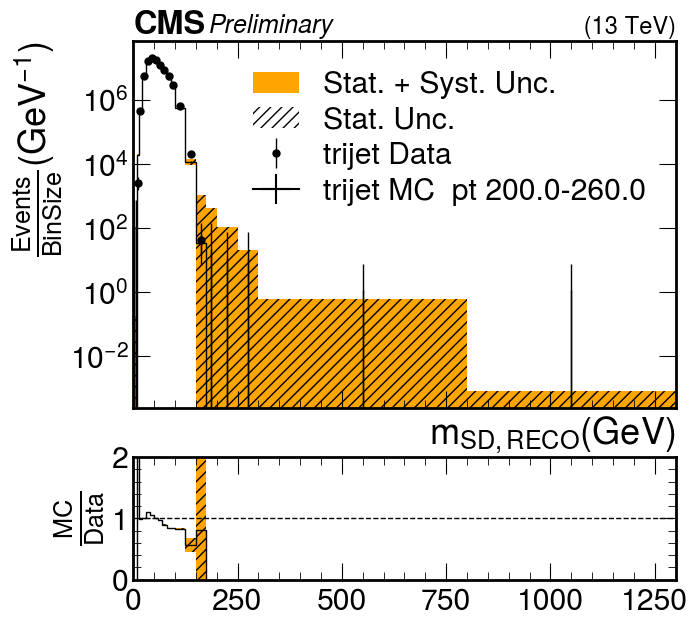

Syst unc up vals:  [0.00000000e+00 2.89501587e-07 3.46069812e+00 6.86539734e+01
 1.74495254e+03 6.11030292e+03 8.49233234e+03 7.89425191e+03
 6.27180744e+03 4.54125131e+03 3.26508863e+03 2.18475054e+03
 2.69938465e+03 8.90433362e+02 3.19805413e+02 1.28739318e+02
 8.03477817e+01 1.91413245e+01 7.96046767e+00 5.53303087e-03]
Syst unc down vals:  [0.00000000e+00 7.02940251e-02 1.36486856e+02 3.92488937e+03
 4.87229277e+04 8.44437305e+04 3.14797357e+04 1.90324301e+05
 1.91661117e+05 1.30034163e+05 9.70767447e+04 4.97535866e+04
 7.70375201e+04 9.30018836e+03 3.09211000e+02 2.88158025e+03
 1.34481923e+02 7.22130699e+01 9.25416392e+00 5.42867347e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 1.77742888e+00 2.52169935e+04 4.07345901e+05
 1.26321005e+07 5.65677091e+07 9.34268201e+07 9.40442697e+07
 7.77932971e+07 6.00787432e+07 4.41609825e+07 3.19533973e+07
 4.19559072e+07 9.67277585e+06 8.6535983

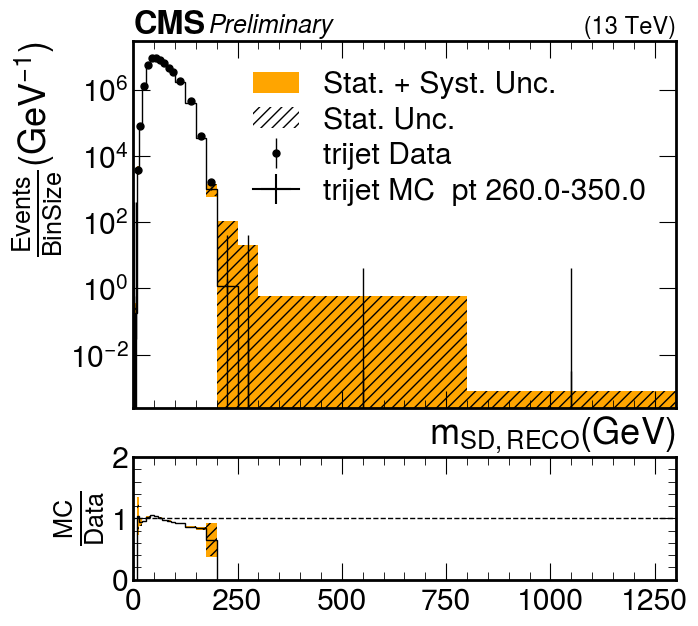

Syst unc up vals:  [0.00000000e+00 2.89501587e-07 3.46069812e+00 6.86539734e+01
 1.74495254e+03 6.11030292e+03 8.49233234e+03 7.89425191e+03
 6.27180744e+03 4.54125131e+03 3.26508863e+03 2.18475054e+03
 2.69938465e+03 8.90433362e+02 3.19805413e+02 1.28739318e+02
 8.03477817e+01 1.91413245e+01 7.96046767e+00 5.53303087e-03]
Syst unc down vals:  [0.00000000e+00 7.02940251e-02 1.36486856e+02 3.92488937e+03
 4.87229277e+04 8.44437305e+04 3.14797357e+04 1.90324301e+05
 1.91661117e+05 1.30034163e+05 9.70767447e+04 4.97535866e+04
 7.70375201e+04 9.30018836e+03 3.09211000e+02 2.88158025e+03
 1.34481923e+02 7.22130699e+01 9.25416392e+00 5.42867347e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 9.75899666e-01 8.22639801e+03 5.92446505e+04
 1.16490645e+06 6.49776608e+06 1.44489616e+07 1.81985587e+07
 1.73018340e+07 1.46818427e+07 1.19964058e+07 9.73303252e+06
 1.64257264e+07 8.68172346e+06 3.3556886

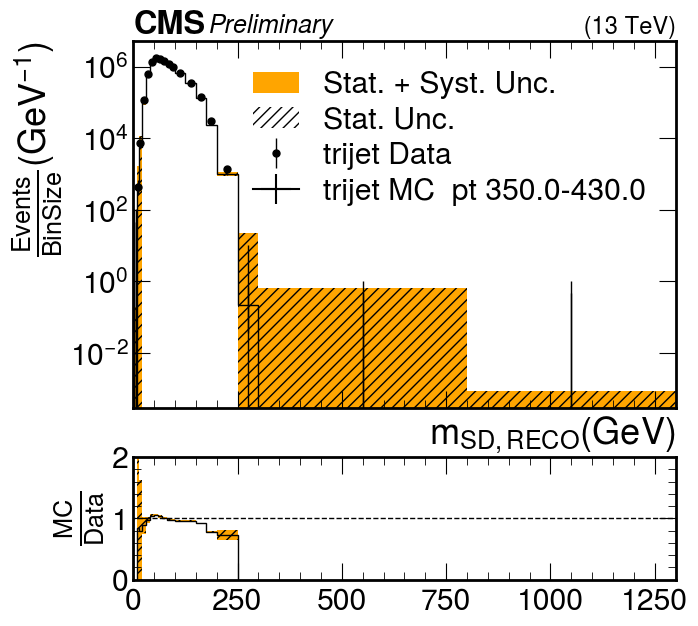

Syst unc up vals:  [0.00000000e+00 2.89501587e-07 3.46069812e+00 6.86539734e+01
 1.74495254e+03 6.11030292e+03 8.49233234e+03 7.89425191e+03
 6.27180744e+03 4.54125131e+03 3.26508863e+03 2.18475054e+03
 2.69938465e+03 8.90433362e+02 3.19805413e+02 1.28739318e+02
 8.03477817e+01 1.91413245e+01 7.96046767e+00 5.53303087e-03]
Syst unc down vals:  [0.00000000e+00 7.02940251e-02 1.36486856e+02 3.92488937e+03
 4.87229277e+04 8.44437305e+04 3.14797357e+04 1.90324301e+05
 1.91661117e+05 1.30034163e+05 9.70767447e+04 4.97535866e+04
 7.70375201e+04 9.30018836e+03 3.09211000e+02 2.88158025e+03
 1.34481923e+02 7.22130699e+01 9.25416392e+00 5.42867347e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 1.01635090e+00 6.89392734e+03 3.52574477e+04
 3.23032541e+05 1.50669235e+06 3.75018884e+06 5.61734357e+06
 6.08093520e+06 5.55108103e+06 4.75655836e+06 3.96656097e+06
 7.26434524e+06 4.62427254e+06 2.7860015

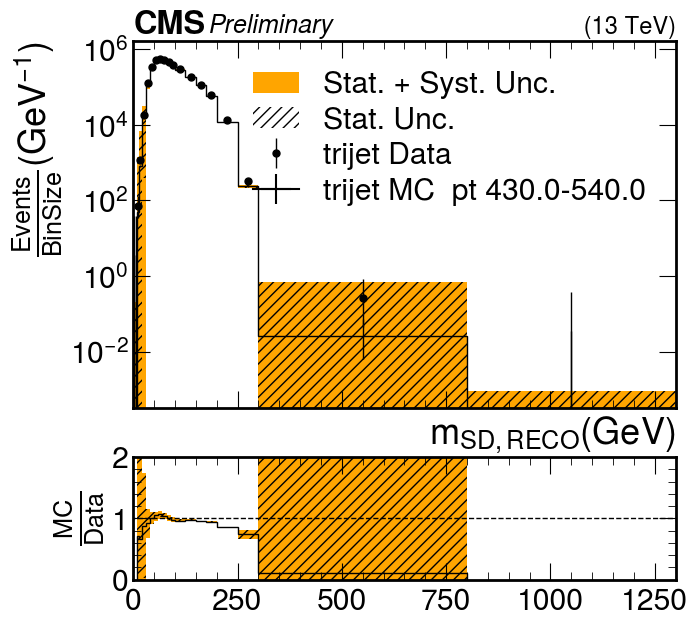

Syst unc up vals:  [0.00000000e+00 2.89501587e-07 3.46069812e+00 6.86539734e+01
 1.74495254e+03 6.11030292e+03 8.49233234e+03 7.89425191e+03
 6.27180744e+03 4.54125131e+03 3.26508863e+03 2.18475054e+03
 2.69938465e+03 8.90433362e+02 3.19805413e+02 1.28739318e+02
 8.03477817e+01 1.91413245e+01 7.96046767e+00 5.53303087e-03]
Syst unc down vals:  [0.00000000e+00 7.02940251e-02 1.36486856e+02 3.92488937e+03
 4.87229277e+04 8.44437305e+04 3.14797357e+04 1.90324301e+05
 1.91661117e+05 1.30034163e+05 9.70767447e+04 4.97535866e+04
 7.70375201e+04 9.30018836e+03 3.09211000e+02 2.88158025e+03
 1.34481923e+02 7.22130699e+01 9.25416392e+00 5.42867347e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 1.11109737e+00 6.89455071e+03 3.27661792e+04
 1.83427295e+05 4.54908556e+05 8.53181851e+05 1.26718199e+06
 1.48573795e+06 1.45639427e+06 1.29044920e+06 1.09779976e+06
 1.97038428e+06 1.34205102e+06 9.1905583

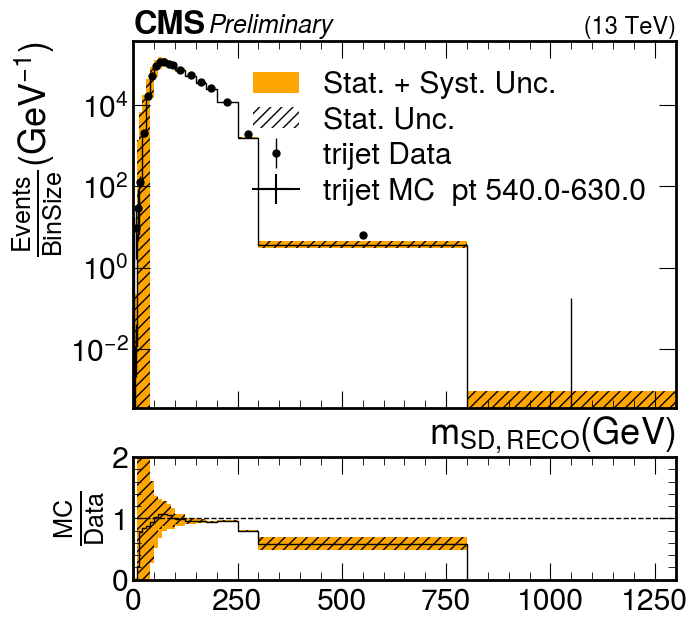

Syst unc up vals:  [0.00000000e+00 2.89501587e-07 3.46069812e+00 6.86539734e+01
 1.74495254e+03 6.11030292e+03 8.49233234e+03 7.89425191e+03
 6.27180744e+03 4.54125131e+03 3.26508863e+03 2.18475054e+03
 2.69938465e+03 8.90433362e+02 3.19805413e+02 1.28739318e+02
 8.03477817e+01 1.91413245e+01 7.96046767e+00 5.53303087e-03]
Syst unc down vals:  [0.00000000e+00 7.02940251e-02 1.36486856e+02 3.92488937e+03
 4.87229277e+04 8.44437305e+04 3.14797357e+04 1.90324301e+05
 1.91661117e+05 1.30034163e+05 9.70767447e+04 4.97535866e+04
 7.70375201e+04 9.30018836e+03 3.09211000e+02 2.88158025e+03
 1.34481923e+02 7.22130699e+01 9.25416392e+00 5.42867347e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 1.05983369e+00 6.94570498e+03 3.26544957e+04
 1.71066794e+05 3.42257963e+05 4.67198743e+05 5.57806618e+05
 6.00413392e+05 5.82655106e+05 5.19638423e+05 4.39771684e+05
 7.12087074e+05 4.64634543e+05 3.2190060

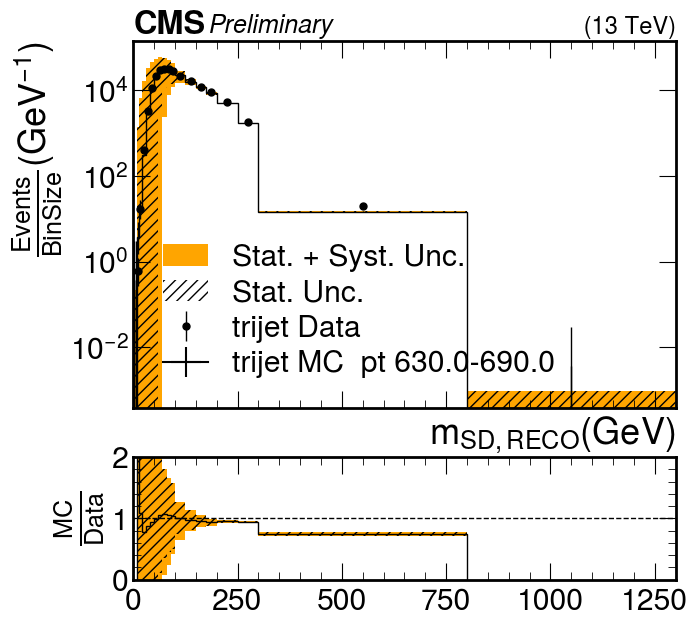

Syst unc up vals:  [0.00000000e+00 2.89501587e-07 3.46069812e+00 6.86539734e+01
 1.74495254e+03 6.11030292e+03 8.49233234e+03 7.89425191e+03
 6.27180744e+03 4.54125131e+03 3.26508863e+03 2.18475054e+03
 2.69938465e+03 8.90433362e+02 3.19805413e+02 1.28739318e+02
 8.03477817e+01 1.91413245e+01 7.96046767e+00 5.53303087e-03]
Syst unc down vals:  [0.00000000e+00 7.02940251e-02 1.36486856e+02 3.92488937e+03
 4.87229277e+04 8.44437305e+04 3.14797357e+04 1.90324301e+05
 1.91661117e+05 1.30034163e+05 9.70767447e+04 4.97535866e+04
 7.70375201e+04 9.30018836e+03 3.09211000e+02 2.88158025e+03
 1.34481923e+02 7.22130699e+01 9.25416392e+00 5.42867347e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 1.11998895e+00 6.90806284e+03 3.25049143e+04
 1.68808049e+05 3.25509552e+05 4.07740346e+05 4.41105855e+05
 4.45386974e+05 4.21288716e+05 3.73429023e+05 3.14571263e+05
 4.71316019e+05 2.96167149e+05 1.9872345

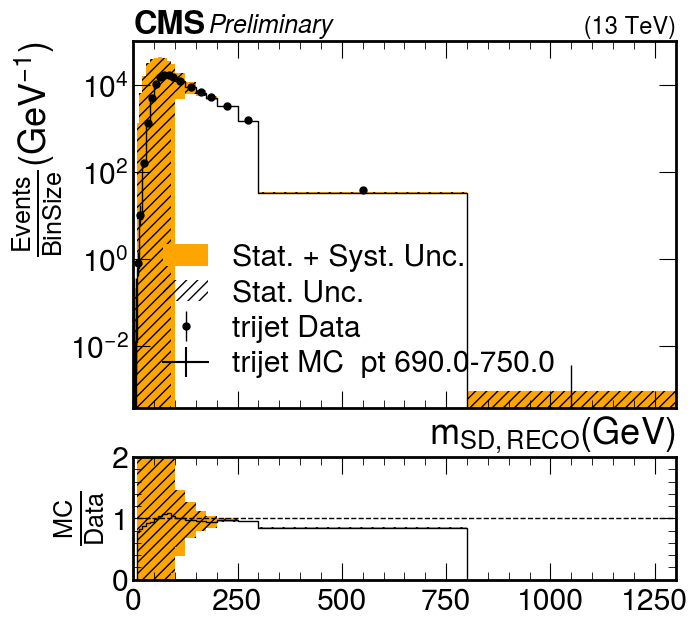

Syst unc up vals:  [0.00000000e+00 2.89501587e-07 3.46069812e+00 6.86539734e+01
 1.74495254e+03 6.11030292e+03 8.49233234e+03 7.89425191e+03
 6.27180744e+03 4.54125131e+03 3.26508863e+03 2.18475054e+03
 2.69938465e+03 8.90433362e+02 3.19805413e+02 1.28739318e+02
 8.03477817e+01 1.91413245e+01 7.96046767e+00 5.53303087e-03]
Syst unc down vals:  [0.00000000e+00 7.02940251e-02 1.36486856e+02 3.92488937e+03
 4.87229277e+04 8.44437305e+04 3.14797357e+04 1.90324301e+05
 1.91661117e+05 1.30034163e+05 9.70767447e+04 4.97535866e+04
 7.70375201e+04 9.30018836e+03 3.09211000e+02 2.88158025e+03
 1.34481923e+02 7.22130699e+01 9.25416392e+00 5.42867347e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 1.07008065e+00 6.99580501e+03 3.28980605e+04
 1.70151918e+05 3.22975579e+05 3.88335348e+05 3.93596454e+05
 3.75206990e+05 3.43072553e+05 2.99598370e+05 2.50378641e+05
 3.47695541e+05 2.07027986e+05 1.3274894

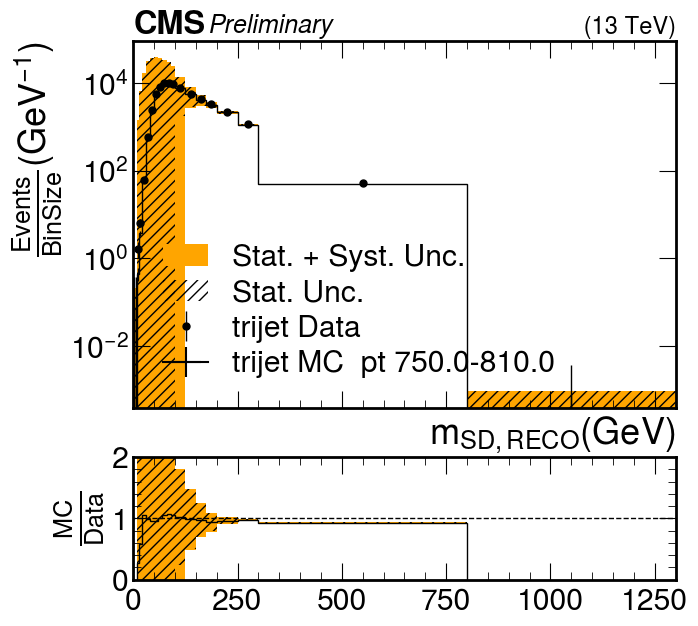

Syst unc up vals:  [0.00000000e+00 2.89501587e-07 3.46069812e+00 6.86539734e+01
 1.74495254e+03 6.11030292e+03 8.49233234e+03 7.89425191e+03
 6.27180744e+03 4.54125131e+03 3.26508863e+03 2.18475054e+03
 2.69938465e+03 8.90433362e+02 3.19805413e+02 1.28739318e+02
 8.03477817e+01 1.91413245e+01 7.96046767e+00 5.53303087e-03]
Syst unc down vals:  [0.00000000e+00 7.02940251e-02 1.36486856e+02 3.92488937e+03
 4.87229277e+04 8.44437305e+04 3.14797357e+04 1.90324301e+05
 1.91661117e+05 1.30034163e+05 9.70767447e+04 4.97535866e+04
 7.70375201e+04 9.30018836e+03 3.09211000e+02 2.88158025e+03
 1.34481923e+02 7.22130699e+01 9.25416392e+00 5.42867347e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 1.31820958e+00 8.60434652e+03 4.04638715e+04
 2.09305624e+05 3.97112526e+05 4.77945084e+05 4.89283285e+05
 4.76221007e+05 4.49832547e+05 4.08245522e+05 3.53342507e+05
 5.33812404e+05 3.33513547e+05 2.2106772

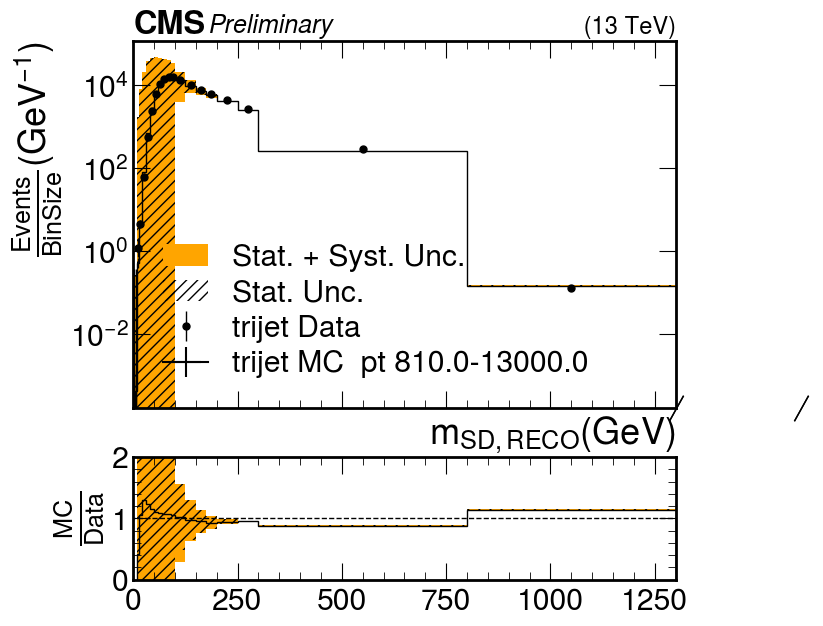

In [9]:
plotDataMCwErrorsBinned(result_mc, result_data, "response_matrix_u", 'ptreco_mreco_u', "mreco", channel = "trijet", rax_lim=[0,2])

Syst unc up vals:  [0.00000000e+00 2.89501587e-07 3.46069812e+00 6.86539734e+01
 1.74495254e+03 6.11030292e+03 8.49233234e+03 7.89425191e+03
 6.27180744e+03 4.54125131e+03 3.26508863e+03 2.18475054e+03
 2.69938465e+03 8.90433362e+02 3.19805413e+02 1.28739318e+02
 8.03477817e+01 1.91413245e+01 7.96046767e+00 5.53303087e-03]
Syst unc down vals:  [0.00000000e+00 7.02940251e-02 1.36486856e+02 3.92488937e+03
 4.87229277e+04 8.44437305e+04 3.14797357e+04 1.90324301e+05
 1.91661117e+05 1.30034163e+05 9.70767447e+04 4.97535866e+04
 7.70375201e+04 9.30018836e+03 3.09211000e+02 2.88158025e+03
 1.34481923e+02 7.22130699e+01 9.25416392e+00 5.42867347e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 1.31791416e+00 8.51703101e+04 1.79927457e+06
 4.66527871e+07 1.62345826e+08 2.20105963e+08 1.98960469e+08
 1.51474702e+08 1.07716327e+08 7.34441017e+07 4.80536540e+07
 5.51368903e+07 1.65716310e+07 5.3651930

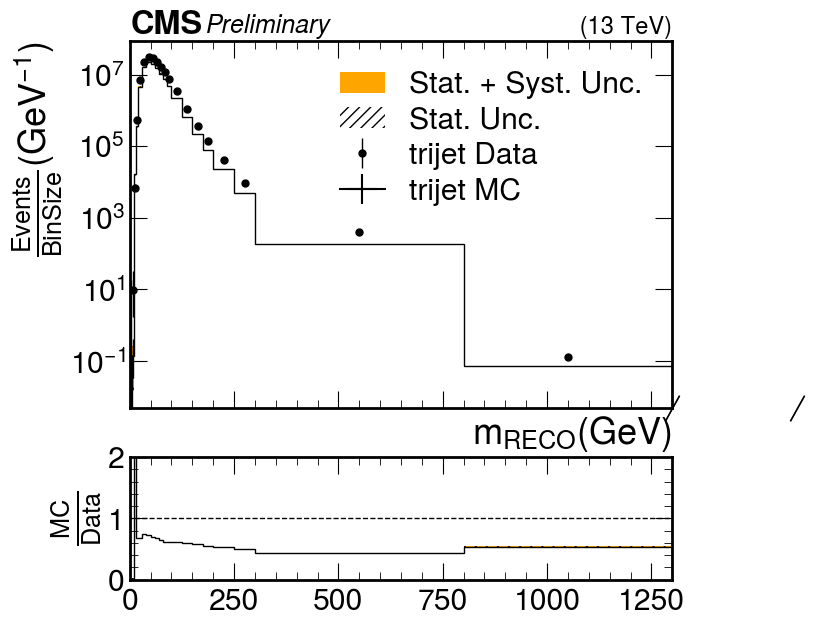

Syst unc up vals:  [0.00000000e+00 2.89501587e-07 3.46069812e+00 6.86539734e+01
 1.74495254e+03 6.11030292e+03 8.49233234e+03 7.89425191e+03
 6.27180744e+03 4.54125131e+03 3.26508863e+03 2.18475054e+03
 2.69938465e+03 8.90433362e+02 3.19805413e+02 1.28739318e+02
 8.03477817e+01 1.91413245e+01 7.96046767e+00 5.53303087e-03]
Syst unc down vals:  [0.00000000e+00 7.02940251e-02 1.36486856e+02 3.92488937e+03
 4.87229277e+04 8.44437305e+04 3.14797357e+04 1.90324301e+05
 1.91661117e+05 1.30034163e+05 9.70767447e+04 4.97535866e+04
 7.70375201e+04 9.30018836e+03 3.09211000e+02 2.88158025e+03
 1.34481923e+02 7.22130699e+01 9.25416392e+00 5.42867347e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 1.93671143e+00 1.25160135e+05 2.64408392e+06
 6.85575655e+07 2.38571697e+08 3.23451821e+08 2.92377932e+08
 2.22596279e+08 1.58292132e+08 1.07928146e+08 7.06161783e+07
 8.10251905e+07 2.43524717e+07 7.8843000

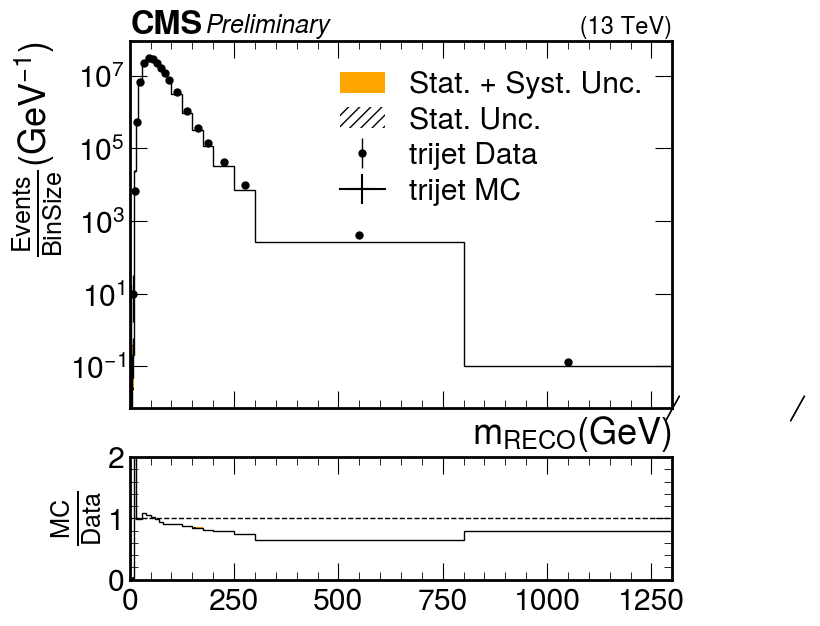

Syst unc up vals:  [0.00000000e+00 0.00000000e+00 6.34317479e+03 4.55009599e+03
 6.54006693e+03 4.88234884e+03 4.17151824e+03 3.92504049e+03
 3.60840058e+03 3.03506145e+03 2.45017417e+03 1.72455972e+03
 2.23870173e+03 7.58859923e+02 2.82552326e+02 1.13906259e+02
 7.26389205e+01 1.79737590e+01 7.59020480e+00 5.80895582e-03]
Syst unc down vals:  [0.00000000e+00 0.00000000e+00 5.44644707e+04 1.62525931e+05
 1.66159280e+05 1.50352985e+04 1.82950005e+04 2.36366581e+04
 3.22636508e+04 6.06575635e+04 2.45794982e+04 3.10376154e+04
 4.49131972e+04 7.32606610e+03 1.75228647e+02 1.75958801e+03
 6.76401613e+01 1.07147585e+02 1.28581408e+01 2.92284654e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 0.00000000e+00 2.43926905e+08 1.70994609e+08
 2.43056459e+08 1.77127686e+08 1.51060431e+08 1.41929335e+08
 1.28851115e+08 1.07246772e+08 8.18595731e+07 5.69875767e+07
 6.81687293e+07 2.09977421e+07 6.8989050

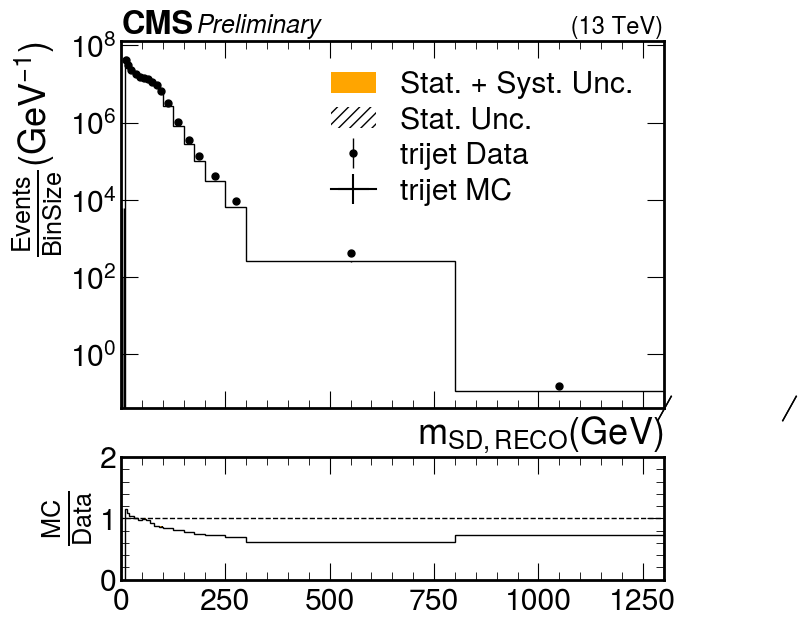

In [10]:
plotDataMCwErrors(result_mc, result_data, "response_matrix_u", 'ptreco_mreco_u', "mreco", IOV=2018, channel = "trijet", rax_lim=[0,2])
plotDataMCwErrors(result_mc, result_data, "ptreco_mreco_u", 'ptreco_mreco_u', "mreco", IOV=2018, channel = "trijet", rax_lim=[0,2], norm=True)
plotDataMCwErrors(result_mc, result_data, "ptreco_mreco_g", 'ptreco_mreco_g', "mreco", IOV=2018, channel = "trijet", rax_lim=[0.0,2], norm=True)

In [11]:
from python.plotting import plotSyst
#plotSyst(result_mc, "response_matrix_u", 'ptreco', label = r'2018 (13 TeV)', IOV='2018', channel='trijet', os_path=os_path)

In [12]:
# plotSyst(result_mc, "response_matrix_u", 'mreco', label = r'2018 (13 TeV)', IOV='2018', channel='trijet')

In [13]:
#### Plot dijet systematics
fname = "coffeaOutput/dijet/dijetHists_JetHT_pt200.0_rapidity2.5_2018.pkl"
fname = "coffeaOutput/dijet/dijetHists_JetHT_newMandPtBins_rapidity2.5_nominal2018.pkl"
with open(fname, "rb") as f:
    result_data = pickle.load( f )
#fname = "coffeaOutput/dijetHists_wXSscaling_QCDsim_pt200.0_rapidity2.5_allUncRespOnlyNEW2018.pkl"
# fname="coffeaOutput/dijet/dijetHists_wXSscaling_QCDsim_pt200.0_rapidity2.5_allUnc2018RespOnly.pkl"
fname = "coffeaOutput/dijet/dijetHists_wXSscaling_QCDsim_newMandPtBins_rapidity2.5_nominal2018.pkl"
with open(fname, "rb") as f:
    result_mc = pickle.load( f )

year = fname[-8:-4]
# fname = "coffeaOutput/trijetHists_JetHT_pt200-Copy1.0_rappidity2.5_NoneHEMveto2018.pkl"
# with open(fname, "rb") as f:
#     result_mc_older = pickle.load( f )
if "trijet" in fname:
    os_path = 'plots/syst/trijet/'
else: os_path = 'plots/syst/dijet/'
# print(result_mc['cutflow'])
checkdir(os_path)

Syst unc up vals:  [0.00000000e+00 9.89807507e-08 4.08279159e+00 8.55526216e+01
 2.42106670e+03 8.38394545e+03 1.12688858e+04 1.01298852e+04
 7.79195252e+03 5.51775197e+03 3.82736446e+03 2.50592081e+03
 3.01028319e+03 9.68797803e+02 3.47410958e+02 1.38422820e+02
 8.64386607e+01 2.07205445e+01 8.54411602e+00 5.89047257e-03]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 6.92628087e+00 7.02508789e+04 1.56639877e+06
 4.38622003e+07 1.46910097e+08 1.80032191e+08 1.46185480e+08
 1.00178402e+08 6.34841967e+07 3.76799571e+07 1.96551868e+07
 1.07836285e+07 2.41179641e+05 1.7886087

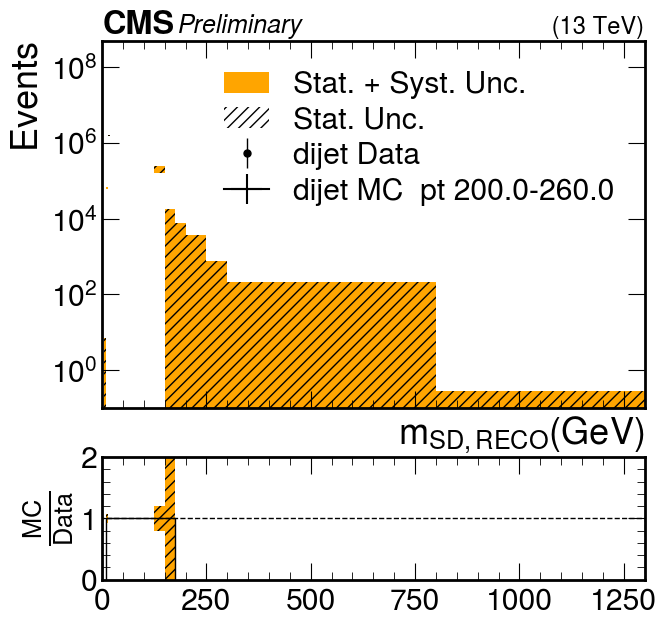

Syst unc up vals:  [0.00000000e+00 9.89807507e-08 4.08279159e+00 8.55526216e+01
 2.42106670e+03 8.38394545e+03 1.12688858e+04 1.01298852e+04
 7.79195252e+03 5.51775197e+03 3.82736446e+03 2.50592081e+03
 3.01028319e+03 9.68797803e+02 3.47410958e+02 1.38422820e+02
 8.64386607e+01 2.07205445e+01 8.54411602e+00 5.89047257e-03]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 6.92628087e+00 1.69215566e+04 2.71121179e+05
 9.27010554e+06 4.42429143e+07 7.45657441e+07 7.47720763e+07
 6.13007702e+07 4.70806606e+07 3.45183490e+07 2.48321901e+07
 3.24977157e+07 7.27289284e+06 6.0521639

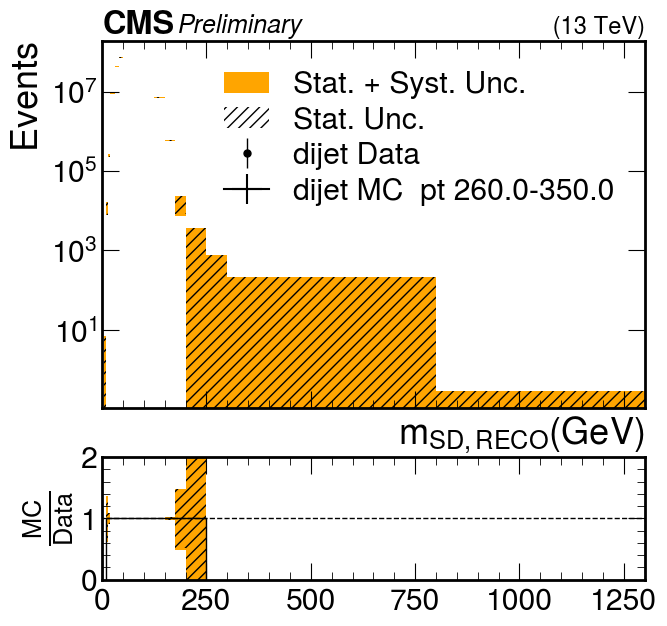

Syst unc up vals:  [0.00000000e+00 9.89807507e-08 4.08279159e+00 8.55526216e+01
 2.42106670e+03 8.38394545e+03 1.12688858e+04 1.01298852e+04
 7.79195252e+03 5.51775197e+03 3.82736446e+03 2.50592081e+03
 3.01028319e+03 9.68797803e+02 3.47410958e+02 1.38422820e+02
 8.64386607e+01 2.07205445e+01 8.54411602e+00 5.89047257e-03]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 1.38105093e+01 5.35169433e+03 3.77572809e+04
 7.55180879e+05 4.44762253e+06 1.01713467e+07 1.28527241e+07
 1.21356661e+07 1.02511751e+07 8.33251102e+06 6.76123753e+06
 1.14134456e+07 6.00807848e+06 2.2944125

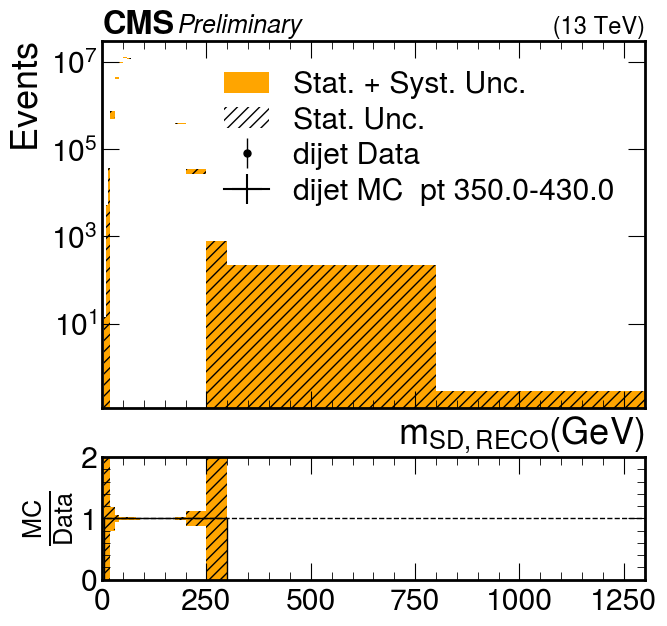

Syst unc up vals:  [0.00000000e+00 9.89807507e-08 4.08279159e+00 8.55526216e+01
 2.42106670e+03 8.38394545e+03 1.12688858e+04 1.01298852e+04
 7.79195252e+03 5.51775197e+03 3.82736446e+03 2.50592081e+03
 3.01028319e+03 9.68797803e+02 3.47410958e+02 1.38422820e+02
 8.64386607e+01 2.07205445e+01 8.54411602e+00 5.89047257e-03]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 6.96328973e+00 4.68759589e+03 2.39658294e+04
 2.12638230e+05 9.95141448e+05 2.53327644e+06 3.81957622e+06
 4.11755933e+06 3.72276693e+06 3.17556324e+06 2.64221477e+06
 4.83945224e+06 3.08026212e+06 1.8546238

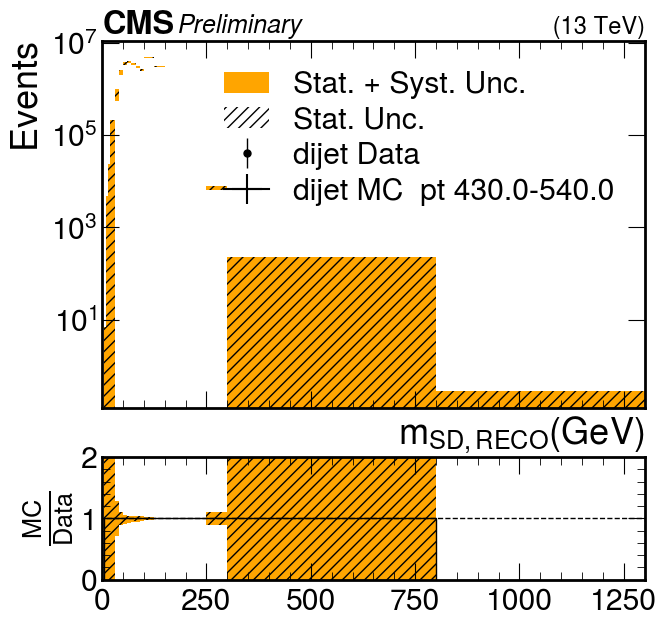

Syst unc up vals:  [0.00000000e+00 9.89807507e-08 4.08279159e+00 8.55526216e+01
 2.42106670e+03 8.38394545e+03 1.12688858e+04 1.01298852e+04
 7.79195252e+03 5.51775197e+03 3.82736446e+03 2.50592081e+03
 3.01028319e+03 9.68797803e+02 3.47410958e+02 1.38422820e+02
 8.64386607e+01 2.07205445e+01 8.54411602e+00 5.89047257e-03]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 7.93091010e+00 4.59822393e+03 2.21692047e+04
 1.28275034e+05 3.09850342e+05 5.71396980e+05 8.43993152e+05
 9.80906015e+05 9.52631904e+05 8.34823514e+05 7.07794524e+05
 1.26432674e+06 8.62111349e+05 5.9073414

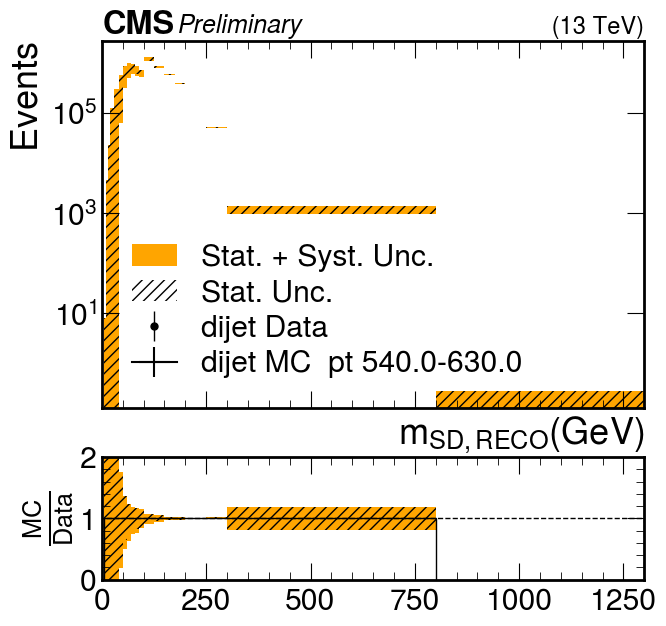

Syst unc up vals:  [0.00000000e+00 9.89807507e-08 4.08279159e+00 8.55526216e+01
 2.42106670e+03 8.38394545e+03 1.12688858e+04 1.01298852e+04
 7.79195252e+03 5.51775197e+03 3.82736446e+03 2.50592081e+03
 3.01028319e+03 9.68797803e+02 3.47410958e+02 1.38422820e+02
 8.64386607e+01 2.07205445e+01 8.54411602e+00 5.89047257e-03]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 7.07411779e+00 4.57967193e+03 2.19799249e+04
 1.20563014e+05 2.38756399e+05 3.18561551e+05 3.73868643e+05
 3.96710513e+05 3.80120332e+05 3.34067941e+05 2.79794326e+05
 4.50396611e+05 2.93409630e+05 2.0384882

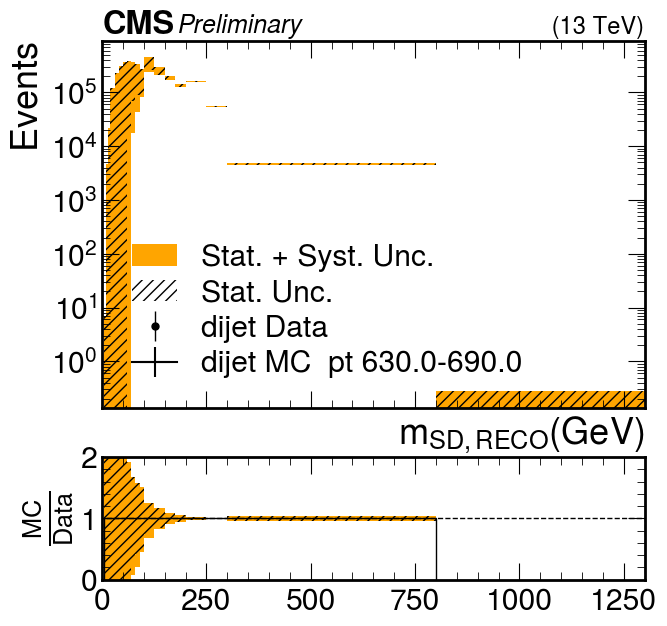

Syst unc up vals:  [0.00000000e+00 9.89807507e-08 4.08279159e+00 8.55526216e+01
 2.42106670e+03 8.38394545e+03 1.12688858e+04 1.01298852e+04
 7.79195252e+03 5.51775197e+03 3.82736446e+03 2.50592081e+03
 3.01028319e+03 9.68797803e+02 3.47410958e+02 1.38422820e+02
 8.64386607e+01 2.07205445e+01 8.54411602e+00 5.89047257e-03]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 6.92628087e+00 4.57721678e+03 2.19474207e+04
 1.19612186e+05 2.29268794e+05 2.81519559e+05 2.98393093e+05
 2.96792288e+05 2.76580066e+05 2.41505349e+05 2.00562606e+05
 2.97940266e+05 1.86603891e+05 1.2536737

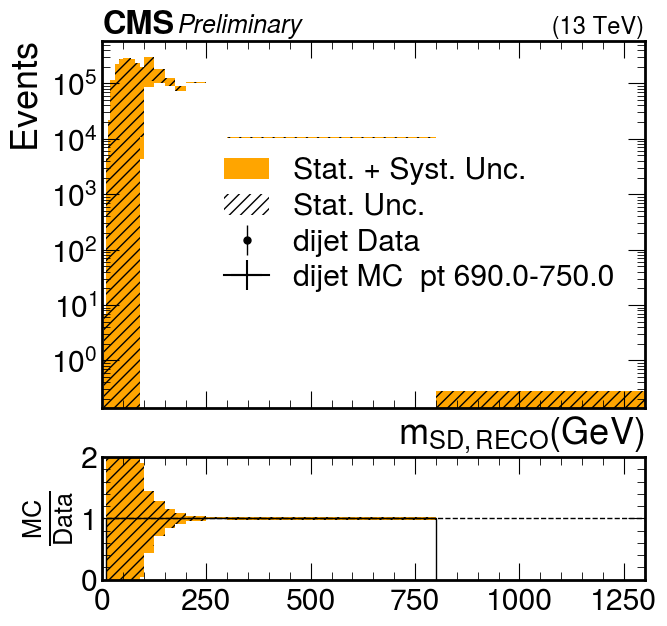

Syst unc up vals:  [0.00000000e+00 9.89807507e-08 4.08279159e+00 8.55526216e+01
 2.42106670e+03 8.38394545e+03 1.12688858e+04 1.01298852e+04
 7.79195252e+03 5.51775197e+03 3.82736446e+03 2.50592081e+03
 3.01028319e+03 9.68797803e+02 3.47410958e+02 1.38422820e+02
 8.64386607e+01 2.07205445e+01 8.54411602e+00 5.89047257e-03]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 6.97027445e+00 4.57558653e+03 2.19375261e+04
 1.19176689e+05 2.25304617e+05 2.65951805e+05 2.64157249e+05
 2.47679039e+05 2.23230693e+05 1.91717151e+05 1.57784976e+05
 2.16539831e+05 1.28087455e+05 8.2365191

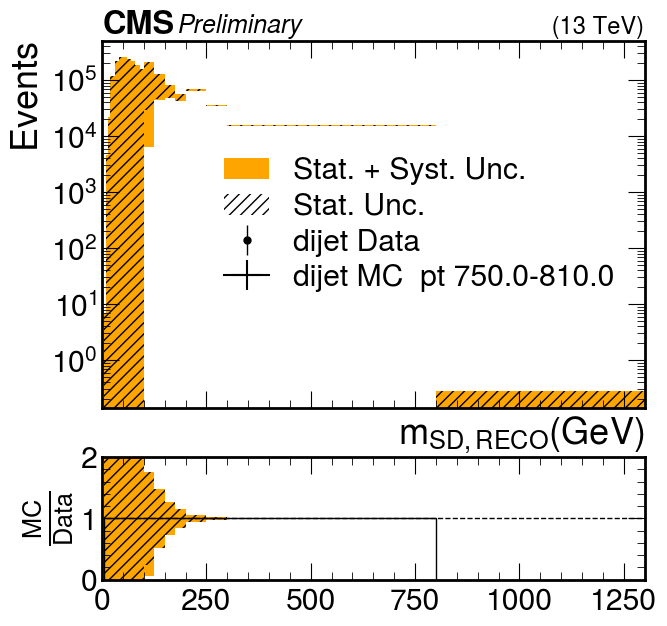

Syst unc up vals:  [0.00000000e+00 9.89807507e-08 4.08279159e+00 8.55526216e+01
 2.42106670e+03 8.38394545e+03 1.12688858e+04 1.01298852e+04
 7.79195252e+03 5.51775197e+03 3.82736446e+03 2.50592081e+03
 3.01028319e+03 9.68797803e+02 3.47410958e+02 1.38422820e+02
 8.64386607e+01 2.07205445e+01 8.54411602e+00 5.89047257e-03]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]
Total unc up:  [0.00000000e+00 6.92994488e+00 4.57636132e+03 2.19372128e+04
 1.19159940e+05 2.25184615e+05 2.66000761e+05 2.66683119e+05
 2.55452482e+05 2.38367094e+05 2.12947011e+05 1.81454824e+05
 2.70284389e+05 1.67471601e+05 1.1130645

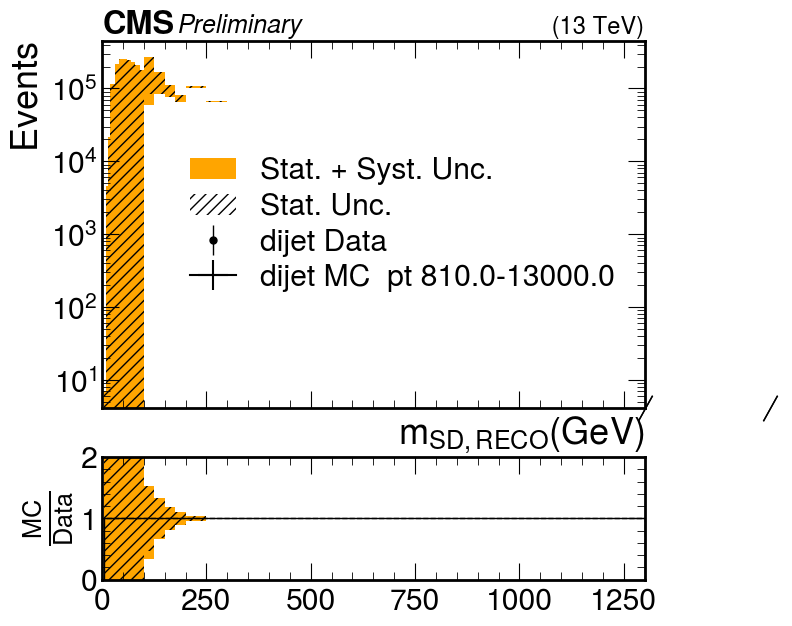

In [14]:
plotDataMCwErrorsBinned(result_mc, result_mc, "response_matrix_u", 'ptreco_mreco_u', "mreco", channel = "dijet", rax_lim=[0,2], binwnorm=False)

Syst unc up vals:  [0.00000000e+00 9.89807507e-08 4.08279159e+00 8.55526216e+01
 2.42106670e+03 8.38394545e+03 1.12688858e+04 1.01298852e+04
 7.79195252e+03 5.51775197e+03 3.82736446e+03 2.50592081e+03
 3.01028319e+03 9.68797803e+02 3.47410958e+02 1.38422820e+02
 8.64386607e+01 2.07205445e+01 8.54411602e+00 5.89047257e-03]
Syst unc down vals:  [0.00000000e+00 1.36349300e-01 9.95511488e+02 7.81005475e+03
 6.99753947e+04 6.21234339e+04 9.18386841e+04 2.13040993e+05
 2.25872200e+05 1.37756786e+05 1.14433822e+05 3.47135950e+04
 6.92651855e+04 8.98802940e+03 1.67508628e+03 2.77431456e+03
 8.77346562e+01 4.23220923e+01 2.70757712e+01 4.44859072e-02]
widths [  5.   5.   5.   5.  10.  10.  10.  10.  10.  10.  10.  10.  25.  25.
  25.  25.  50.  50. 500. 500.]


ValueError: operands could not be broadcast together with shapes (20,) (18,) (18,) 

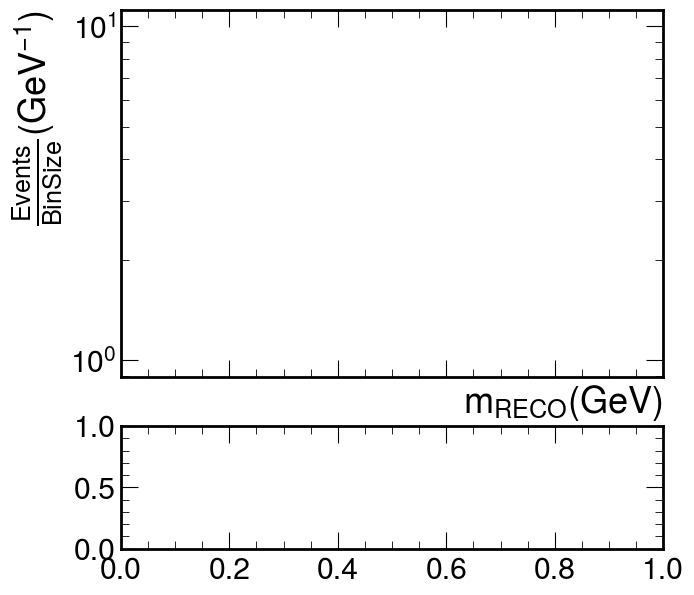

In [15]:

plotDataMCwErrors(result_mc, result_data, "ptreco_mreco_u", 'ptreco_mreco_u', "mreco", IOV=2018, channel = "dijet", rax_lim=[0,2])
plotDataMCwErrors(result_mc, result_data, "ptreco_mreco_g", 'ptreco_mreco_g', "mreco", IOV=2018, channel = "dijet")
plotDataMCwErrors(result_mc, result_data, "ptreco_mreco_g", 'ptreco_mreco_g', "ptreco", IOV=2018, channel = "dijet", norm=True)
plotDataMCwErrors(result_mc, result_data, "ptreco_mreco_u", 'ptreco_mreco_u', "mreco", IOV=2018, channel = "dijet", norm=True, rax_lim=[0,2])
plotDataMCwErrors(result_mc, result_data, "ptreco_mreco_g", 'ptreco_mreco_g', "mreco", IOV=2018, channel = "dijet", norm=True, rax_lim=[0,2])


In [ ]:

#plotSyst(result_mc, "response_matrix_u", 'ptreco', label = r'2018 (13 TeV)', IOV='2018', channel='dijet')


In [ ]:

plotSyst(result_mc, "response_matrix_u", 'mreco', label = r'2018 (13 TeV)', IOV='2018', channel='dijet')


In [ ]:
#### Plot dijet systematics

histname="ptreco_mreco_u"
availAxes = [ax.name for ax in result_hem[histname].axes]
availSysts = [ax for ax in result_hem[histname].project("syst").axes[0]]
print([ax for ax in result_hem[histname].project("syst").axes[0]])
print("Available axes: ", availAxes)
print("Available systs ", availSysts)
def compareDatasets(result, histname, axVar, syst=None):
    if syst==None:
        syst = "nominal"
    edges = [bin[0] for bin in result[0][histname].project(axVar).axes[0]] + [result[0][histname].project(axVar).axes[0][-1][1]]
    fig, (ax, rax) = plt.subplots(
                nrows=2,
                ncols=1,
                figsize=(7,7),
                gridspec_kw={"height_ratios": (3, 1)},
                sharex=True)
    ratio = np.divide(result[0][histname][{'syst':syst}].project(axVar).values(),result[1][histname][{"syst":"nominal"}].project(axVar).values(),
                                    out=np.empty(np.array(result[1][histname][{"syst":syst}].project(axVar).values()).shape).fill(np.nan),
                                    where=result[1][histname][{"syst":syst}].project(axVar).values()!= 0,)
    hep.histplot(ratio, edges, stack=True, histtype='step', ax=rax, density=False, linestyle ="-", color = 'red', linewidth=1)
    hep.histplot(result[0][histname][{'syst':"nominal"}].project(axVar), stack=False, histtype='step', binwnorm=True, ax=ax, density=False, linestyle ='-', color = 'red', linewidth=1,label="hemVeto")
    hep.histplot(result[1][histname][{'syst':"nominal"}].project(axVar), stack=False, histtype='step', binwnorm=True, ax=ax, density=False, linestyle ='-', linewidth=1,label=syst)
    #### Fill ratio plot
    ax.set_xlabel(None)
    ax.autoscale(axis='x', tight=True)
    leg = ax.legend(loc='best', labelspacing=0.25)
    leg.set_visible(True)
    hep.histplot(np.ones_like(ratio), edges, stack=False, histtype='step',ax=rax, density=False, linestyle ="--", color = 'black', linewidth=1)
    rax.set_ylabel(r'$\frac{HEMveto}{Nominal}$', loc = 'center')
    rax.set_ylim(0.9,1.1)
compareDatasets([result_hem, result], 'ptreco_mreco_u', 'mreco')
compareDatasets([result_hem, result], 'ptreco_mreco_u', 'ptreco')

In [ ]:
data = [result[histname][{'syst':"nominal"}].project('mreco'), 
                  result[histname][{'syst':"nominal"}].project('mreco'),
         result[histname][{'syst':"nominal"}].project('ptreco'), 
                  result[histname][{'syst':"nominal"}].project('ptreco')]
hemdata = [result_hem[histname][{'syst':"nominal"}].project('mreco'), 
              result_hem[histname][{'syst':"nominal"}].project('mreco'),
     result_hem[histname][{'syst':"nominal"}].project('ptreco'), 
              result_hem[histname][{'syst':"nominal"}].project('ptreco')]
for i, mchist in enumerate(data):
    fig, ax, = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(7,7))
    # ax.autoscale(axis='x', tight=True)
    # grid = fig.add_gridspec(4,1, figure=fig, wspace=0, hspace=0)
    num = hemdata[i]
    denom = data[i]
    # main_ax = fig.add_subplot(grid[:-1, :])
    # plt.setp(main_ax.get_xticklabels(), visible=False)
    # main_ax.set_yscale("log")
    # main_ax.set_xlim([0,2200])
    # subplot_ax = fig.add_subplot(grid[-1, :], sharex=main_ax)
    main_ax, sublot_ax = num.plot_ratio(denom,
                                          rp_num_label='hem',
                                          rp_denom_label="nominal",
                                          rp_uncert_draw_type="line",)
                                          # ax_dict = {"main_ax":main_ax,"ratio_ax":subplot_ax})
    plt.ylabel("HEM/Nominal")
    plt.savefig(os_path+"/compareDataHEM_test.png")